4983


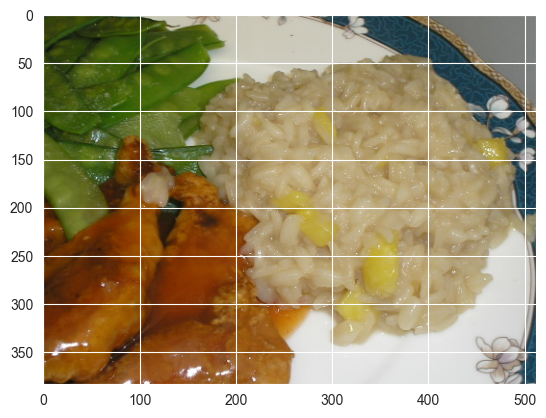

In [5]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from datasets import load_dataset
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dataset = load_dataset("EduardoPacheco/FoodSeg103")

train_dataset, validate_dataset = dataset["train"], dataset["validation"]

print(len(train_dataset))

img = train_dataset[0]["image"]
plt.imshow(img)


In [6]:
import numpy as np
def extract_ingredients(chosen_images):
    mask = np.array(chosen_images["label"])
    unique_labels = np.unique(mask)
    # we also filter out category 0, since 0 = background
    unique_labels = unique_labels[unique_labels != 0]
    chosen_images["ingredients"] = unique_labels.tolist()
    return chosen_images

train = train_dataset.map(extract_ingredients)
validation = validate_dataset.map(extract_ingredients)

In [7]:
num_of_classes = 104

def one_hot_encode(example):
    ingredient_vector = np.zeros(num_of_classes, dtype=np.float32)
    for cls in example["ingredients"]:
        ingredient_vector[int(cls)] = 1.0
    example["ingredient_vector"] = ingredient_vector
    return example

train = train.map(one_hot_encode)
validation = validation.map(one_hot_encode)

In [8]:
from torchvision import transforms
from PIL import Image

IMG_SIZE = 224
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

small_train_ds = train.select(range(4000))
small_val_ds = validation.select(range(1000))

def preprocess(example):
    img = example["image"]
    if not isinstance(img, Image.Image):
        img = Image.fromarray(img)
    example["image"] = transform(img)
    return example


# Apply preprocessing to all examples
train_torch = small_train_ds.map(preprocess)
validation_torch = small_val_ds.map(preprocess)

# ⚠️ Important: keep only tensor columns for DataLoader
train_torch.set_format(type="torch", columns=["image", "ingredient_vector"])
validation_torch.set_format(type="torch", columns=["image", "ingredient_vector"])

print(train_torch[0]["image"].shape)  # should print torch.Size([3, 224, 224])

Map: 100%|██████████| 1000/1000 [00:50<00:00, 19.64 examples/s]

torch.Size([3, 224, 224])


In [9]:
from torchvision.models import resnet50, ResNet50_Weights

model = resnet50(weights=ResNet50_Weights.DEFAULT)


In [10]:
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import torch

IMG_SIZE = 224
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

def collate_fn(batch):
    """
    Custom collate function to:
      - resize images to (224, 224)
      - convert them to tensors
      - stack ingredient vectors
    """
    images = []
    labels = []

    for b in batch:
        img = b["image"]
        if not isinstance(img, Image.Image):
            img = Image.fromarray(img)
        img = transform(img)
        images.append(img)
        labels.append(torch.tensor(b["ingredient_vector"], dtype=torch.float32))

    images = torch.stack(images)
    labels = torch.stack(labels)

    return {"image": images, "ingredient_vector": labels}

# Now create DataLoaders safely
batch_size = 32
train_dataloader = DataLoader(small_train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
validate_dataloader = DataLoader(small_val_ds, batch_size=batch_size, collate_fn=collate_fn)


In [11]:
import torch.optim as optim
from tqdm import tqdm

# Freeze all layers except the last one (optional, can comment out if full finetuning desired)
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer to match our number of ingredient classes
model.fc = nn.Linear(model.fc.in_features, num_of_classes)
model = model.to(device)

# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss()  # For multi-label classification
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

# Training loop
num_epochs = 5  # You can increase this once it runs correctly

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Training phase
    loop = tqdm(train_dataloader, desc=f"Epoch [{epoch + 1}/{num_epochs}] - Training", leave=False)
    for batch in loop:
        images = batch["image"].to(device)
        labels = batch["ingredient_vector"].to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        loop.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(train_torch)
    print(f"Epoch [{epoch + 1}/{num_epochs}] Training Loss: {epoch_loss:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(validate_dataloader, desc=f"Epoch [{epoch + 1}/{num_epochs}] - Validation", leave=False):
            images = batch["image"].to(device)
            labels = batch["ingredient_vector"].to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

    val_loss /= len(validation_torch)
    print(f"Epoch [{epoch + 1}/{num_epochs}] Validation Loss: {val_loss:.4f}")

# Save the fine-tuned model
torch.save(model.state_dict(), "resnet50_foodseg103_multilabel.pth")
print("✅ Training complete. Model saved to 'resnet50_foodseg103_multilabel.pth'")


Epoch [1/5] Training Loss: 0.1537


Epoch [1/5] Validation Loss: 0.1179


Epoch [2/5] Training Loss: 0.1115


Epoch [2/5] Validation Loss: 0.1094


Epoch [3/5] Training Loss: 0.1013


Epoch [3/5] Validation Loss: 0.1043


Epoch [4/5] Training Loss: 0.0947


Epoch [4/5] Validation Loss: 0.1018


Epoch [5/5] Training Loss: 0.0886


Epoch [5/5] Validation Loss: 0.0996
✅ Training complete. Model saved to 'resnet50_foodseg103_multilabel.pth'


In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

print("\n🔍 Running final evaluation on validation set...")

model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for batch in tqdm(validate_dataloader, desc="Evaluating"):
        images = batch["image"].to(device)
        labels = batch["ingredient_vector"].cpu().numpy()

        outputs = model(images)
        preds = torch.sigmoid(outputs).cpu().numpy()

        all_labels.append(labels)
        all_preds.append(preds)

# Concatenate all batches
all_labels = np.concatenate(all_labels, axis=0)
all_preds = np.concatenate(all_preds, axis=0)

# Convert probabilities to binary (0/1) using threshold = 0.5
binary_preds = (all_preds > 0.5).astype(int)

# Compute metrics
precision = precision_score(all_labels, binary_preds, average="macro", zero_division=0)
recall = recall_score(all_labels, binary_preds, average="macro", zero_division=0)
f1 = f1_score(all_labels, binary_preds, average="macro", zero_division=0)

print(f"\n📊 Validation Results:")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-score:  {f1:.4f}")

# Optionally, show a few sample predictions for inspection
num_show = 5
for i in range(num_show):
    probs = all_preds[i]
    true_labels = np.where(all_labels[i] == 1)[0]
    pred_labels = np.where(binary_preds[i] == 1)[0]

    print(f"\n🖼️ Sample {i + 1}")
    print(f"True ingredients: {true_labels.tolist()}")
    print(f"Predicted ingredients: {pred_labels.tolist()}")
    print(f"Confidence (avg of predicted): {probs[pred_labels].mean() if len(pred_labels) > 0 else 0:.3f}")



🔍 Running final evaluation on validation set...


Evaluating: 100%|██████████| 32/32 [01:14<00:00,  2.32s/it]


📊 Validation Results:
  Precision: 0.2545
  Recall:    0.0702
  F1-score:  0.0999

🖼️ Sample 1
True ingredients: [20, 56, 66, 84, 96]
Predicted ingredients: [84]
Confidence (avg of predicted): 0.936

🖼️ Sample 2
True ingredients: [56, 84, 95]
Predicted ingredients: [84]
Confidence (avg of predicted): 0.526

🖼️ Sample 3
True ingredients: [35, 40, 52, 58, 73]
Predicted ingredients: [58]
Confidence (avg of predicted): 0.620

🖼️ Sample 4
True ingredients: [4, 29, 41]
Predicted ingredients: []
Confidence (avg of predicted): 0.000

🖼️ Sample 5
True ingredients: [52, 54, 58]
Predicted ingredients: [52]
Confidence (avg of predicted): 0.849
